In [81]:
from cvm.utils import UnitConvert as uc
from matplotlib import pyplot as plt

from pprint import pprint

from cvm.A1 import Tetrahedron, TetraOctahedron
from cvm.sample import Sample
from cvm.vibration import ClusterVibration

from cvm.utils import parse_formula, mixed_atomic_weight, parse_input_set, UnitConvert, cvm_context
import numpy as np
import pandas as pd

In [92]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def percent(x, pos=0):
    return u'{:3.1f}'.format(100 * x)


def process(meta, *results, experiment=None):    

    def percent(x, pos=0):
        return u'{:3.1f}'.format(100 * x)
    
    fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)  # 800 * 500
    plt.subplots_adjust(top=0.97, bottom=0.14, left=0.12, right=0.97)

    # draw experiment
    if experiment is not None:
        y_exp = experiment['temperature']
        x_exp = experiment['concentration']
        # ax.annotate('1200$K$', (0.005, 410), fontsize=13)
        ax.plot(
            x_exp, y_exp, 'x--', mew=3, mfc='w', ms=6, lw=1.5, label='Experiment')

    # draw results
    line_type = ['o-', 'o--', 'o:']
    for i, res in enumerate(results):
        # plt.xlim(xmin=0.5, xmax=12.5)
        # plt.axhline(y=0, color='k', ls='-', lw=1.0)
        # label[i] = 'int= ' + '{:07.4}'.format(Results[i]['1st_int'])
        ax.plot(
            res['c'],
            res['temp'],
            # 'o-',
            line_type[i],
            color='darkorange',
            ms=4,
            lw=1.5,
            label=res['label'])

    # set formater
    ax.xaxis.set_major_formatter(FuncFormatter(percent))
#     ax.set_xlim(0, 0.122)

    # for preview
    ax.grid(axis='y')
    ax.tick_params(labelsize=14.5)
    ax.set_ylabel(r'Temperature, $T$/K', size=16)
    ax.set_xlabel(
        r'Concentration of ' + meta['impurity'].capitalize() +
        r', $c$/at$\%$',
        size=16)
#     ax.annotate(
#         r'(b)CVMTO10, with thermal vibration effect', (0.003, 1830), size=15)
#     ax.annotate(r'$T_\mathrm{FD}=1600$K', (0.004, 1630), size=17)
    ax.legend(loc='lower right', markerscale=1.2, fontsize=15)
    fig_name = "_".join(
        (meta['prefix'], meta['host'], meta['impurity'])).lstrip('_')
#     plt.savefig(fig_name, dpi=600)  # 300 dpi
    plt.show()



# Reading input set

In [102]:
# tetra = Tetrahedron.from_input_set('AlMg')
tetra = TetraOctahedron.from_input_set('PdRh')

with cvm_context(simple_print='True'):
    print(tetra)

TetraOctahedron:
  | 
  |-meta:
  |   |-host: pd
  |   |-impurity: rh
  |   |-prefix: 
  |   |-description: pdru solubility limit calculation with tetrahedron approximation
  |   |-structure: a1
  |   |-timestamp: 2019-08-10 05:49:15
  | 
  |-800k--<skip: False>


# calcaulation

# Test model fitting

### check total energy

The results are shifted by stripping the values of minimum energy of *Host* and *impurity*, respectively.

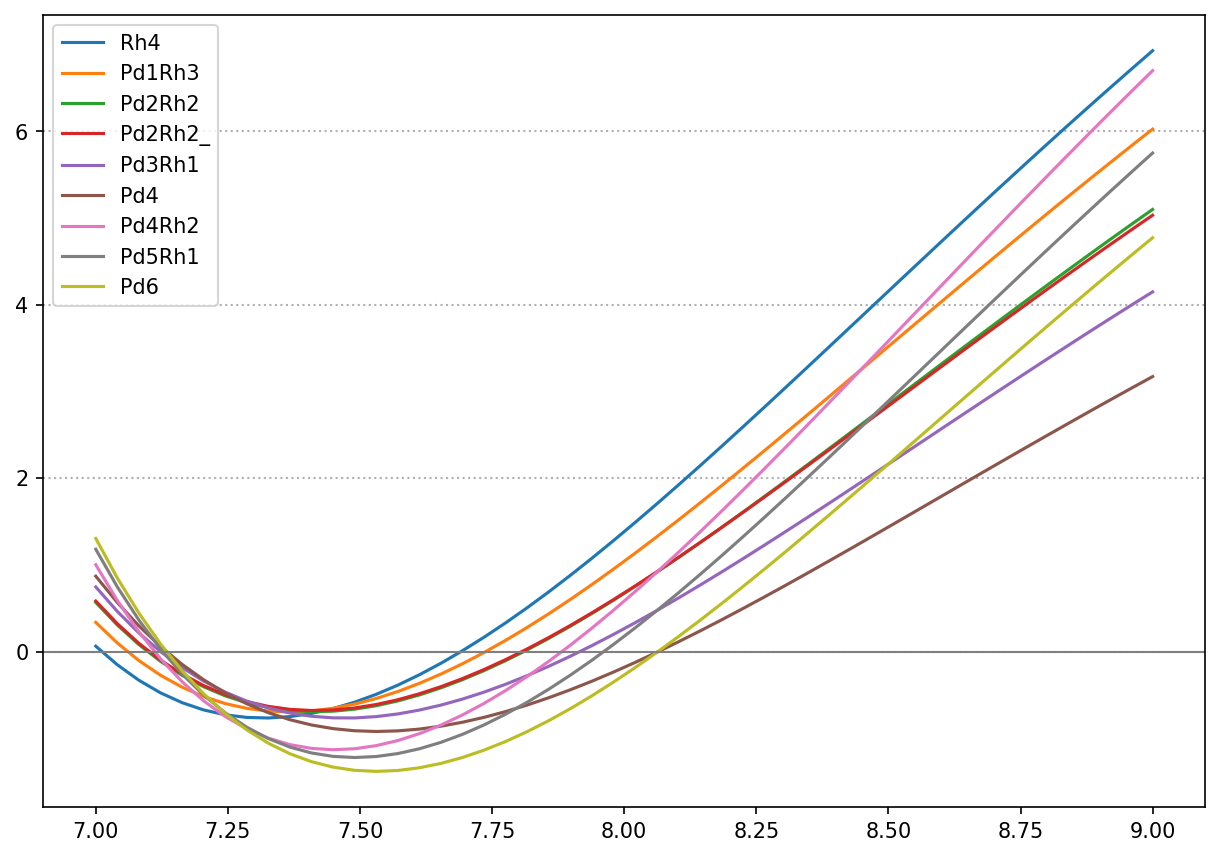

In [103]:
from collections import OrderedDict

plt.figure(figsize=(10, 7), dpi=150)

# ls = np.linspace(6.8, 8.0, 50)
ls = np.linspace(7.0, 9.0, 50)
ls_ = UnitConvert.lc2ad(ls)

sample = tetra.tag_800k
for k, v in sample.items():
    t = [v(T=700, r=r) for r in ls_]
    plt.plot(ls, t, label=k)
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

### check interaction energy

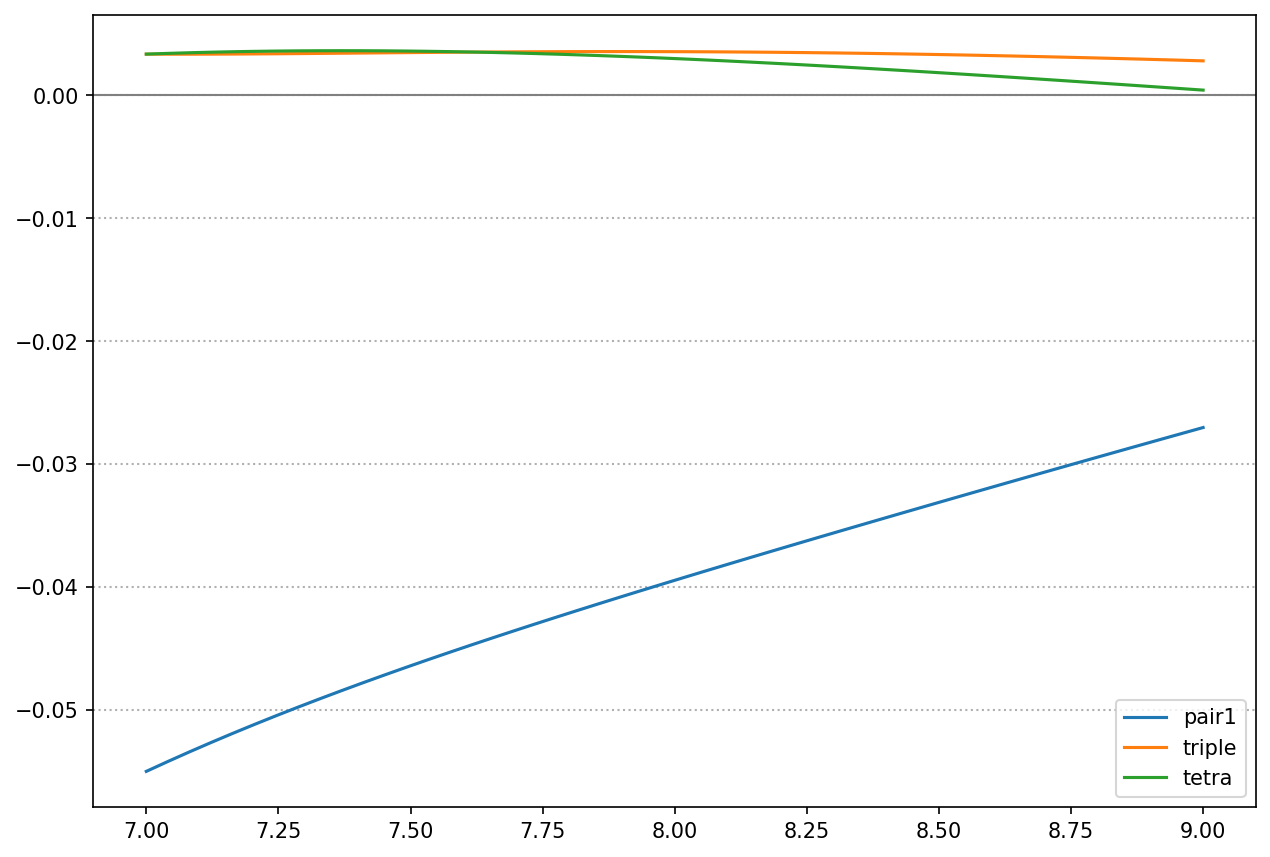

In [104]:
from collections import OrderedDict

plt.figure(figsize=(10, 7), dpi=150)

# ls = np.linspace(6.8, 8.2, 50)
ls = np.linspace(7.0, 9.0, 50)
ls_ = UnitConvert.lc2ad(ls)

sample = tetra.tag_800k
t = pd.DataFrame([sample(T=200, r=r) for r in ls_])

for c in t:
    if c is 'pair2':
        continue
    plt.plot(ls, t[c], label=c)
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

### check energy patch

In [105]:
def patch(_, r0):

    r0 = UnitConvert.ad2lc(r0)
    _1st = -0.071 + (-0.00365 * (r0 - 7.85) / 0.1)
    
    return {'pair1': -0.00}

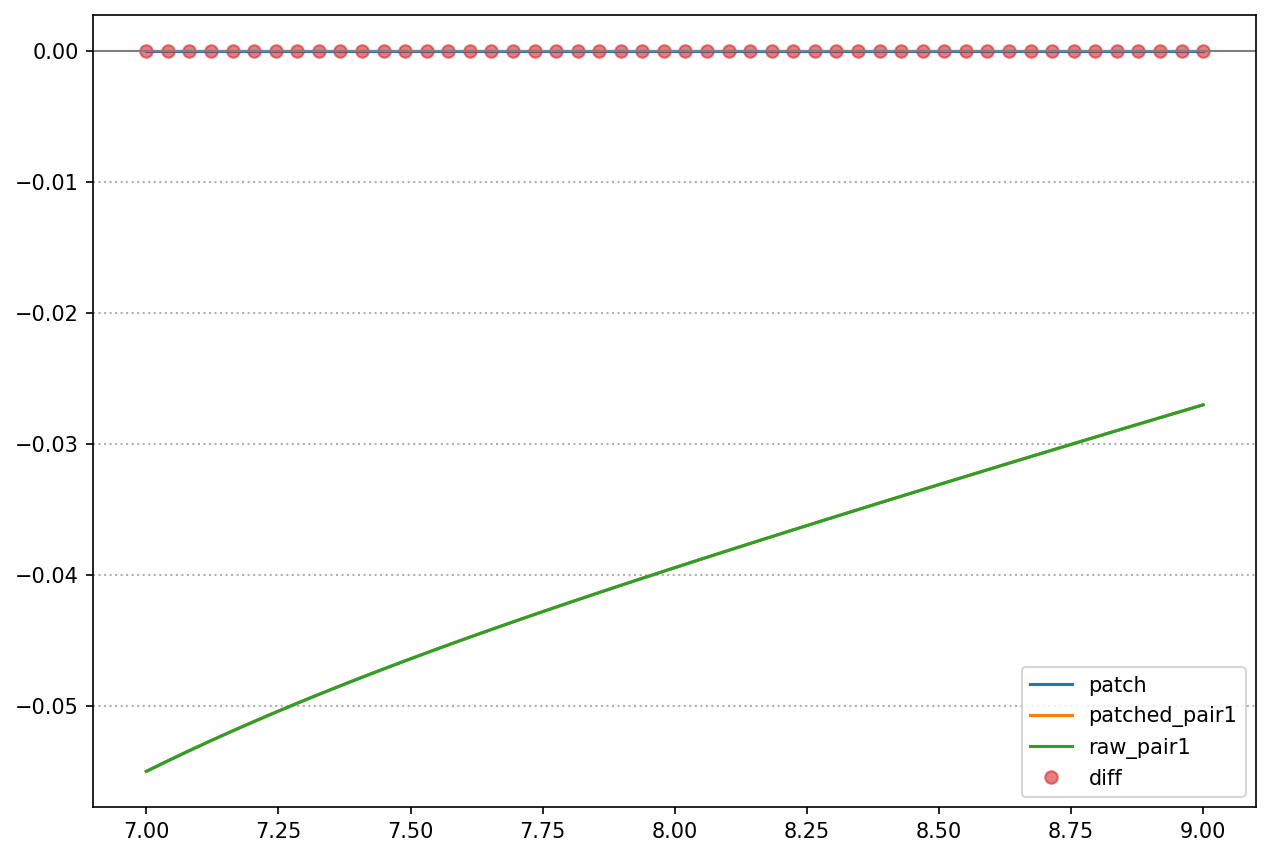

In [106]:
from collections import OrderedDict

plt.figure(figsize=(10, 7), dpi=150)

ls = np.linspace(7.0, 9.0, 50)
ls_ = UnitConvert.lc2ad(ls)

sample = tetra.tag_800k

patch_en = [patch(120, r)['pair1'] for r in ls_]
patched_en = [sample(r=r, energy_patch=patch).pair1 for r in ls_]
raw_en = [sample(r=r).pair1 for r in ls_]

t = pd.DataFrame(dict(patch=patch_en, patched_pair1=patched_en, raw_pair1=raw_en))

for c in t:
    plt.plot(ls, t[c], label=c)
plt.plot(ls, t['patched_pair1'] - t['raw_pair1'], 'o', label='diff', alpha=0.6)
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

# CVM calculation

In [ ]:
# tetra.run(sample_paras=dict(energy_patch=patch))
tetra.run(sample_paras=dict(vibration=False, energy_patch=patch))

800k:  40%|████      | 12/30 [00:01<00:02,  8.57it/s]

In [99]:
tetra.results.head(3)

,temperature,concentration,num_of_ite,pair1,pair2,triple,tetra
label,,,,,,,
800k,400.0,0.000971,1,-0.04696,-0.046964,0.003461,0.003613
800k,400.0,0.000948,2,-0.04696,-0.046964,0.003461,0.003613
800k,400.0,0.000928,3,-0.04696,-0.046963,0.003461,0.003613


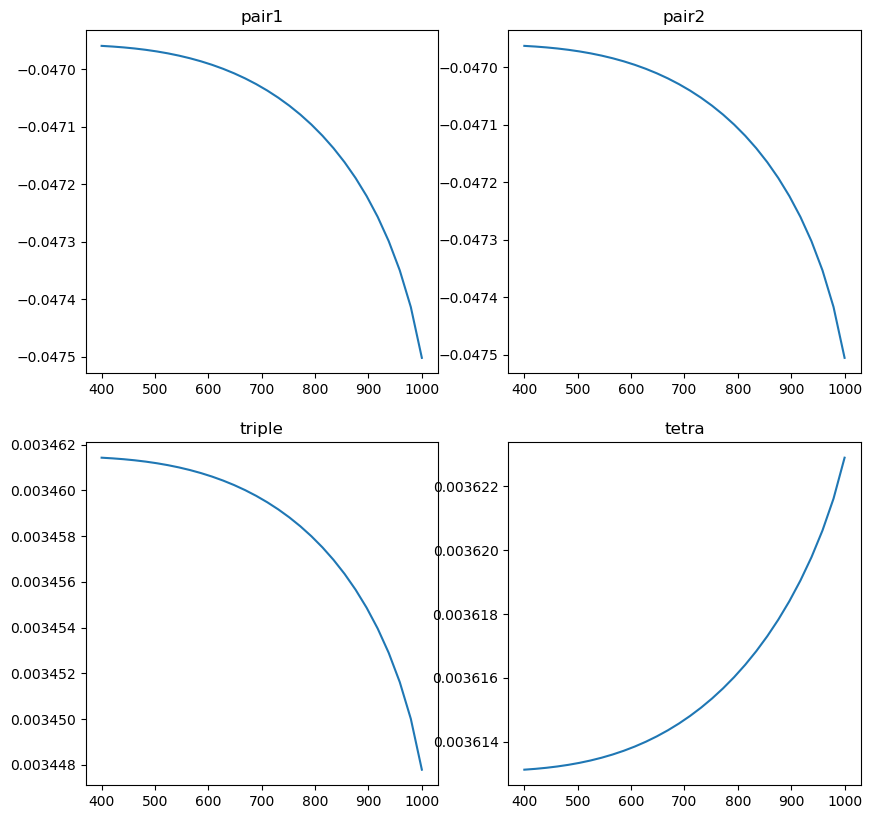

In [100]:
_, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)

ret = tetra.results.groupby('temperature').last()['pair1']
ax[0, 0].set_title('pair1')
ax[0, 0].plot(ret)


ret = tetra.results.groupby('temperature').last()['pair2']
ax[0, 1].set_title('pair2')
ax[0, 1].plot(ret)

ret = tetra.results.groupby('temperature').last()['triple']
ax[1, 0].set_title('triple')
ax[1, 0].plot(ret)

ret = tetra.results.groupby('temperature').last()['tetra']
ax[1, 1].set_title('tetra')
ax[1, 1].plot(ret)

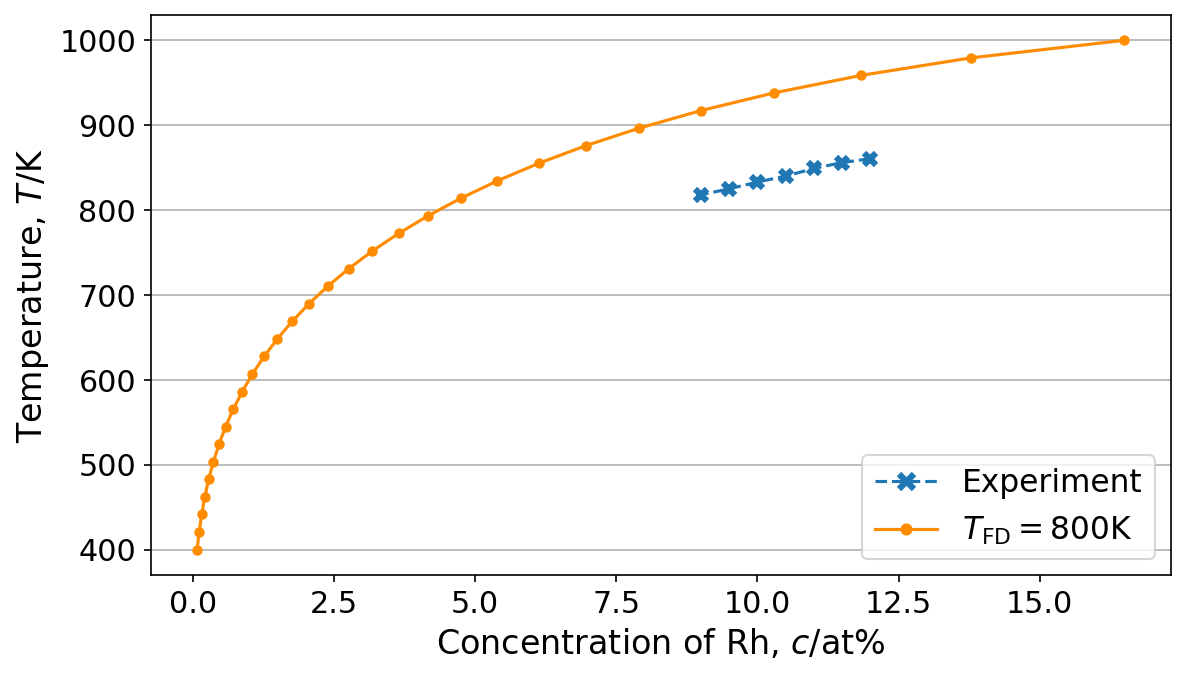

In [101]:
tmp = tetra.results.groupby('temperature').last()
process(tetra.meta, dict(temp=tmp.index.values, c=tmp['concentration'].values, label='$T_\\mathrm{FD}=800$K'), experiment=tetra.experiment)